# Quantitative analysis of the binaries in the RGB

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import PolygonSelector, Button
from matplotlib.path import Path
import csv

%matplotlib widget

In [2]:
import sys
import os

# set the path to the tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

In [3]:
colormap = plt.cm.jet

In [4]:
# load and clean data
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt'
df = pd.read_csv(input_file, header=None, delim_whitespace=True, 
                   usecols=[0, 1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32], 
                   names=['X','Y','F275W','rad_275','F336W','rad_336','F435W','rad_435','F606W','rad_606','F814W','rad_814','prob_member'], skiprows=55)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [5]:
# flag the data that are ok (membership probability and radxs)
# set the conditions
conditions = (
    (df['prob_member'] >= 90) & 
    (np.abs(df['rad_275']) < 0.05) &
    (np.abs(df['rad_336']) < 0.05) &
    (np.abs(df['rad_435']) < 0.05) &
    (np.abs(df['rad_606']) < 0.05) &
    (np.abs(df['rad_814']) < 0.05) 
    )   

# assign the flag 
df['flag'] = np.where(conditions, 1, 0)

In [6]:
# select the data with flag 1 
data = df[df['flag'] == 1]

In [7]:
primary_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/primary_stars.csv', delim_whitespace=True)
primary_stars['index'] = primary_stars.index
color_test = colors = binary.color_index(primary_stars, 'index', colormap)

BS_RGB_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_vis.csv', delim_whitespace=True)
BS_RGB_uv = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_RGB_uv.csv', delim_whitespace=True)

color_vis = binary.color_index(BS_RGB_vis, 'secondary', colormap)
color_uv = binary.color_index(BS_RGB_uv, 'secondary', colormap)

In [32]:
primary_vis_high = BS_RGB_vis[BS_RGB_vis['primary'] == 9]
primary_vis_low = BS_RGB_vis[BS_RGB_vis['primary'] == 13]

bound_bin_vis_high = primary_vis_high[primary_vis_high['secondary'] == 3]
bound_bin_vis_low = primary_vis_low[primary_vis_low['secondary'] == 3]

primary_uv_high = BS_RGB_uv[BS_RGB_uv['primary'] == 9]
primary_uv_low = BS_RGB_uv[BS_RGB_uv['primary'] == 13]

bound_bin_uv_high = primary_uv_high[primary_uv_high['secondary'] == 3]
bound_bin_uv_low = primary_uv_low[primary_uv_low['secondary'] == 3]

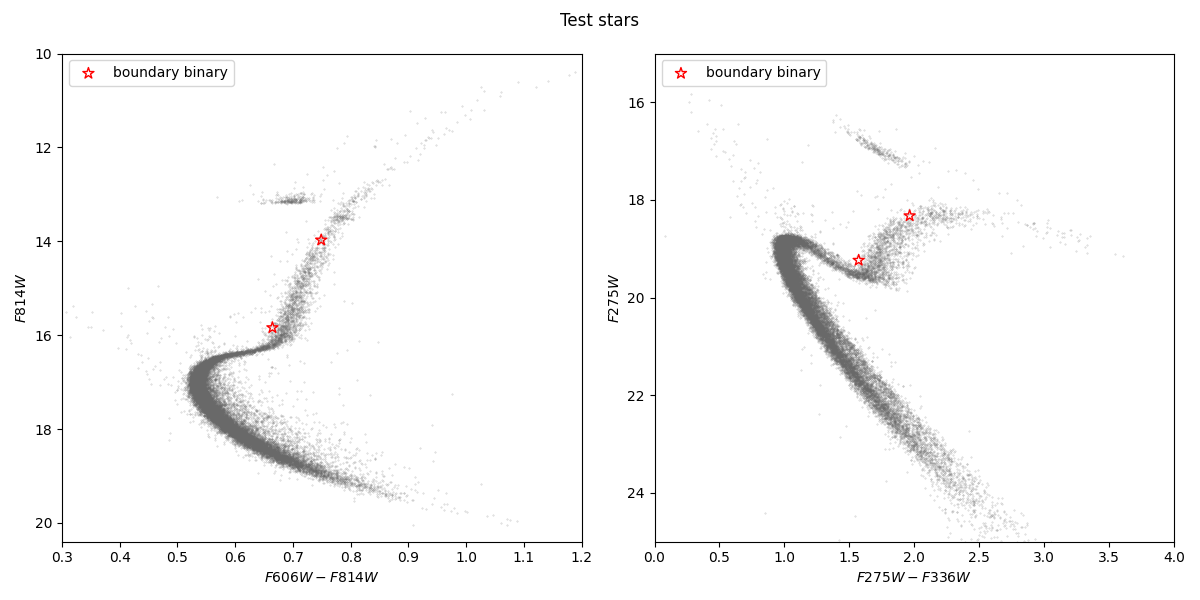

In [33]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(bound_bin_vis_high['F606W']-bound_bin_vis_high['F814W'], bound_bin_vis_high['F814W'], s=70, edgecolor='red', facecolors='none', label='boundary binary', marker='*', zorder=5)
plt.scatter(bound_bin_vis_low['F606W']-bound_bin_vis_low['F814W'], bound_bin_vis_low['F814W'], s=70, edgecolor='red', facecolors='none', marker='*', zorder=5)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)
plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(bound_bin_uv_high['F275W']-bound_bin_uv_high['F336W'], bound_bin_uv_high['F275W'], s=70, edgecolor='red', facecolors='none', label='boundary binary', marker='*', zorder=5)
plt.scatter(bound_bin_uv_low['F275W']-bound_bin_uv_low['F336W'], bound_bin_uv_low['F275W'], s=70, edgecolor='red', facecolors='none', marker='*', zorder=5)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Test stars')
plt.tight_layout()
plt.show()

### Optical CMD

In [34]:
# Do you need to select the stars?
region_selection = True

In [35]:
from CMDAnalyzer import CMDRegionSelector

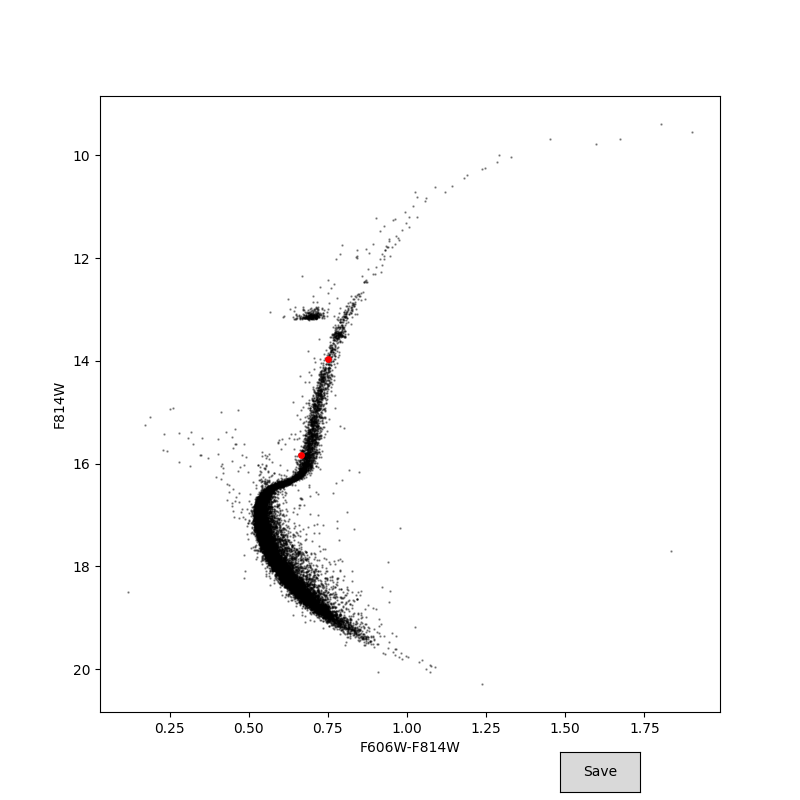

Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Save button clicked!
Region saved.
Regions saved to '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv'.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
P

In [36]:
if region_selection is True:
    cmd_select_vis = CMDRegionSelector(
        data = data,
        color = data['F606W'] - data['F814W'],
        magnitude = data['F814W'],
        color_bound_bin_high = bound_bin_vis_high['F606W'] - bound_bin_vis_high['F814W'],
        magnitude_bound_bin_high = bound_bin_vis_high['F814W'],
        color_bound_bin_low = bound_bin_vis_low['F606W'] - bound_bin_vis_low['F814W'],
        magnitude_bound_bin_low = bound_bin_vis_low['F814W'],
        x_label='F606W-F814W',
        y_label='F814W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv'
    )

In [37]:
region_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

region_vis_A = CMDRegionSelector.get_stars_inside_region(
    region_id = 0,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

region_vis_B = CMDRegionSelector.get_stars_inside_region(
    region_id = 1,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F606W_F814W.csv')

print('Stars in Region A:', len(region_vis_A))
print('Stars in Region B:', len(region_vis_B))

frac_RGB_bin_vis = len(region_vis_B) / (len(region_vis_A) + len(region_vis_B))
print('Binary fraction:', frac_RGB_bin_vis)

Stars in Region A: 1264
Stars in Region B: 143
Binary fraction: 0.10163468372423597


In [38]:
region_names = {
    0: 'Region A',
    1: 'Region B',
}

region_colors = {
    0: 'red',
    1: 'blue',
}

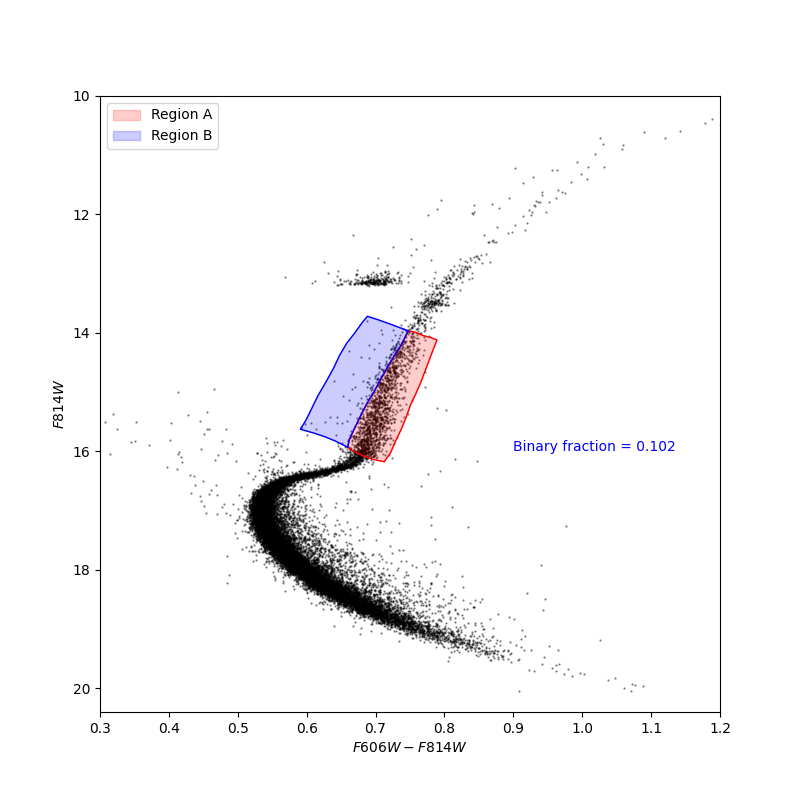

In [39]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.invert_yaxis()
ax.set_xlim(0.3, 1.2)
ax.set_ylim(20.4, 10)
ax.set_xlabel(r'$F606W-F814W$')
ax.set_ylabel(r'$F814W$')

# Group by Region_ID and plot each region
for region_id, region in region_vis.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text to the plot using the value of the variable
ax.text(0.9, 16, f'Binary fraction = {frac_RGB_bin_vis:.3f}', fontsize=10, color='blue')

ax.legend()
plt.show()

### UV CMD

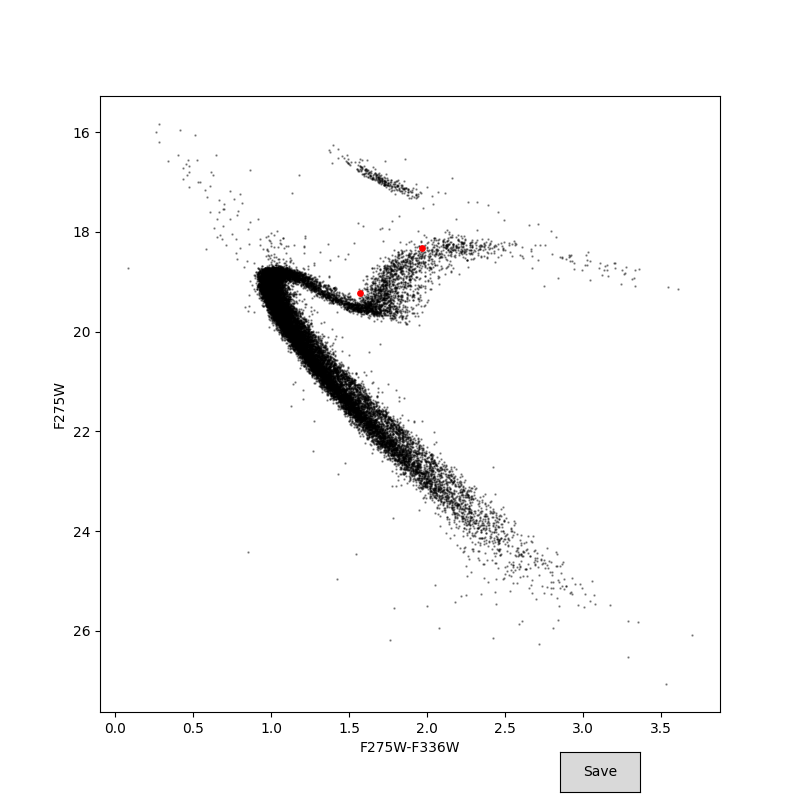

Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Save button clicked!
Region saved.
Regions saved to '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F275W_F336W.csv'.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
Polygon completed. Adjust or confirm selection.
P

In [40]:
if region_selection is True:
    cmd_select_uv = CMDRegionSelector(
        data = data,
        color = data['F275W'] - data['F336W'],
        magnitude = data['F275W'],
        color_bound_bin_high = bound_bin_uv_high['F275W'] - bound_bin_uv_high['F336W'],
        magnitude_bound_bin_high = bound_bin_uv_high['F275W'],
        color_bound_bin_low = bound_bin_uv_low['F275W'] - bound_bin_uv_low['F336W'],
        magnitude_bound_bin_low = bound_bin_uv_low['F275W'],
        x_label='F275W-F336W',
        y_label='F275W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F275W_F336W.csv'
    )

In [41]:
region_uv = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F275W_F336W.csv')

region_uv_A = CMDRegionSelector.get_stars_inside_region(
    region_id = 0,
    data = data, 
    color = data['F275W']-data['F336W'], 
    magnitude = data['F275W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F275W_F336W.csv')

region_uv_B = CMDRegionSelector.get_stars_inside_region(
    region_id = 1,
    data = data, 
    color = data['F275W']-data['F336W'], 
    magnitude = data['F275W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_RGB_F275W_F336W.csv')

print('Stars in Region A:', len(region_uv_A))
print('Stars in Region B:', len(region_uv_B))

frac_RGB_bin_uv = len(region_uv_B) / (len(region_uv_A) + len(region_uv_B))
print('Binary fraction:', frac_RGB_bin_uv)

Stars in Region A: 1131
Stars in Region B: 186
Binary fraction: 0.14123006833712984


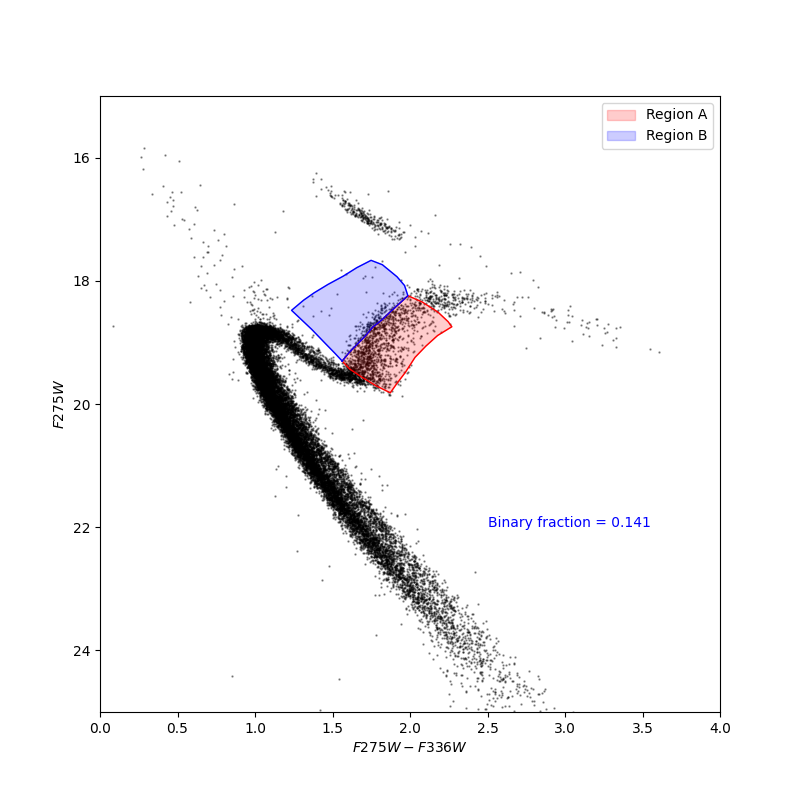

In [42]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F275W'] - data['F336W'], data['F275W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.invert_yaxis()
ax.set_xlim(0, 4)
ax.set_ylim(25, 15)
ax.set_xlabel(r'$F275W-F336W$')
ax.set_ylabel(r'$F275W$')

# Group by Region_ID and plot each region
for region_id, region in region_uv.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text to the plot using the value of the variable
ax.text(2.5, 22, f'Binary fraction = {frac_RGB_bin_uv:.3f}', fontsize=10, color='blue')

ax.legend()
plt.show()

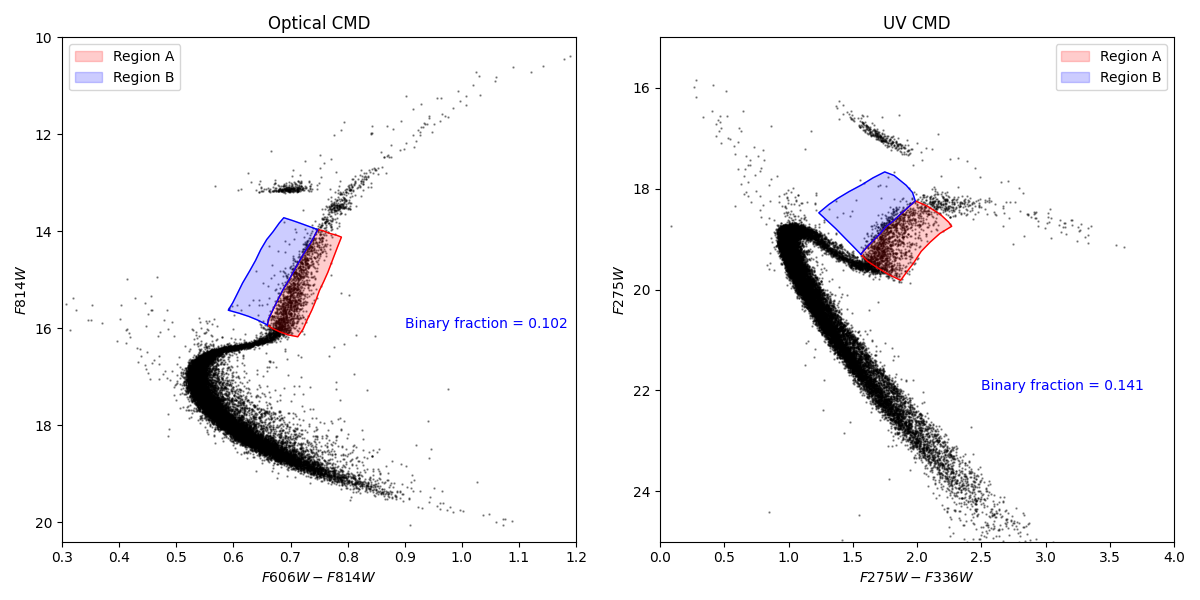

In [46]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First CMD plot
ax1 = axes[0]
scatter1 = ax1.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax1.invert_yaxis()
ax1.set_xlim(0.3, 1.2)
ax1.set_ylim(20.4, 10)
ax1.set_xlabel(r'$F606W-F814W$')
ax1.set_ylabel(r'$F814W$')
ax1.set_title("Optical CMD")

# Plot regions for first CMD
for region_id, region in region_vis.groupby("Region_ID"):
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")

    ax1.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)
    ax1.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text annotation
ax1.text(0.9, 16, f'Binary fraction = {frac_RGB_bin_vis:.3f}', fontsize=10, color='blue')
ax1.legend()

# Second CMD plot
ax2 = axes[1]
scatter2 = ax2.scatter(data['F275W'] - data['F336W'], data['F275W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax2.invert_yaxis()
ax2.set_xlim(0, 4)
ax2.set_ylim(25, 15)
ax2.set_xlabel(r'$F275W-F336W$')
ax2.set_ylabel(r'$F275W$')
ax2.set_title("UV CMD")

# Plot regions for second CMD
for region_id, region in region_uv.groupby("Region_ID"):
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")

    ax2.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)
    ax2.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text annotation
ax2.text(2.5, 22, f'Binary fraction = {frac_RGB_bin_uv:.3f}', fontsize=10, color='blue')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()